# Gaussian Process Models for Quantitative Finance

# Jupyter Notebook Python Companion Code for Chapter 1: Gaussian Process Preliminaries

**Authors**: Mike Ludkovski and Jimmy Risk

The following notebook provides code to reproduce most of the plots in Chapter 1. We focus on introducing various aspects of GP surrogates based on a univariate synthetic response function $$f(x) = -0.1 x^2 + \sin(3x).$$ 

For GP modeling we work with the ``GPyTorch`` library.

## Imports

In [1]:
# Hide notebook warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt

### Importing Helper Functions

A few helper functions are used to cater ``GPyTorch`` ([GPyTorch Documentation](https://docs.gpytorch.ai/en/stable/))  to our setting, contained in the ``easyGPR_helper.py`` script (*a stripped down version of the [EasyGPR](https://github.com/jimmyrisk/EasyGPR) package*)

* ``set_gpytorch_settings``: turns off approximate inference and other settings, which allows for exact BIC calculations (*and offers a speed-up in certain cases like ours*)
* ``GPRModel``: GP Regression Model class. Handles fitting, training, prediction, switching data types, etc., all in one class.

We recommend the interested reader to examine ``easyGPR_helper.py`` for details.  The ``GPRModel`` class can be modified to e.g. perform advanced GP modelling techniques (like in Chapter 3 of the textbook). 

In [3]:
from easyGPR_helper import set_gpytorch_settings, GPRModel

set_gpytorch_settings()

## First Example

As a start, we show a manually constructed collection of 5 inputs $x$ and 5 corresponding training outputs $y$. We then consider three GP models for this data with different hyperparameters, namely observation noise variance $\sigma_\epsilon^2$, outputscale $\eta^2$ and lengthscale $\ell_{len}$ for the SE (squared-exponential or RBF) kernel $k_{SE}(\cdot)$.

In [4]:
# Define the training data points
x_train = np.array([0.5, 1.5, 2, 2.5, 3.5]).reshape(-1, 1)
y_train = np.array([1,0.5,0.75,0.25,0])

# Define a range for testing/predictions
x_test = torch.linspace(0, 5, 100).unsqueeze(1)

In [5]:
from gpytorch.kernels import ScaleKernel, RBFKernel

# SE is same as RBF
rbf_kernel = ScaleKernel(
    RBFKernel()
)

# Define the GPR model with the RBF kernel
model1 = GPRModel(train_x=x_train, train_y=y_train, kernel=rbf_kernel, mean = None)
model2 = GPRModel(train_x=x_train, train_y=y_train, kernel=rbf_kernel, mean = None)
model3 = GPRModel(train_x=x_train, train_y=y_train, kernel=rbf_kernel, mean = None)

We manually set the hyperparameters:

In [6]:
model1.likelihood.noise = 1e-4
model1.kernel.outputscale = 1.0
model1.kernel.base_kernel.lengthscale = 1.0/3
model2.likelihood.noise = 1e-8  # no noise apart from a small jitter
model2.kernel.outputscale = 1.0
model2.kernel.base_kernel.lengthscale = 1.0/3
model3.likelihood.noise = 0.1**2
model3.kernel.outputscale = 1.0
model3.kernel.base_kernel.lengthscale = 1.0/3

In [7]:
import copy
# Make predictions with the models
# Use the prior
predictions1 = copy.deepcopy(model1.make_predictions(x_test, type="f", return_type="numpy", posterior=False))

predictions2 = copy.deepcopy(model2.make_predictions(x_test, type="f", return_type="numpy"))

predictions3 = copy.deepcopy(model3.make_predictions(x_test, type="f", return_type="numpy"))

We next draw `n_paths=3` samples from the above models

In [8]:
seed = 946
torch.manual_seed(seed)
np.random.seed(seed)

n_paths = 3

model1_paths = []
model2_paths = []
model3_paths = []
model1.train()

for i in range(n_paths):
    model1_paths.append(model1.simulate(x_test, method = 'prior'))
    model2_paths.append(model2.simulate(x_test, method = 'posterior'))
    model3_paths.append(model3.simulate(x_test, method = 'posterior'))

In [9]:
# helper Function to plot the graphs
def plot_graph(ax, x_train, y_train, predictions, title, sim_list=None):
    mean_line, = ax.plot(x_test.cpu().numpy().flatten(), predictions.mean, color='black', linewidth=2, linestyle='--')
    if sim_list is not None:
        for sim in sim_list:
            sample_path_line, = ax.plot(x_test.cpu().numpy().flatten(), sim, linewidth=1.5, label='Sample Path')
    ci = ax.fill_between(x_test.cpu().numpy().flatten(),
                         predictions.mean - 1.96 * np.sqrt(predictions.variance),
                         predictions.mean + 1.96 * np.sqrt(predictions.variance),
                         alpha=0.25, color='black')
    ax.set_xlim(0, 5)
    ax.set_ylim(-2.5, 2.5)
    ax.set_title(title)
    if title != "Prior":
        ax.scatter(x_train, y_train, color='blue', s=40, marker='o', alpha=0.9)    
    if ax != axes[0]:
        ax.set_yticklabels([])
    if title == "Prior":
        mean_line.set_label('$\mu(x)$')
        ci_label = '$\mu(x) \pm 1.96 \sigma^2(x)$'
        ax.legend([mean_line, (ci,)], ['$\mu(x)$', '$\mu(x) \pm 1.96 \sigma(x)$'], loc='lower left', fontsize='small')
    elif title == "Posterior ($\sigma_{\epsilon} = 0$)":
        ax.legend([mean_line, (ci,), sample_path_line], ['$m(x)$', '$m(x) \pm 1.96 s(x)$', 'Sample Path'], loc='lower left', fontsize='small')

The next graph matches **Figure 2.1** in the book. The left-most panel shows 3 samples from the prior. The middle panel shows 3 posterior samples given the 5 training input-output pairs and assuming zero observation noise. The right panel shows the same GP regression posterior but assuming observation variance of $\sigma_\epsilon=0.1$. 

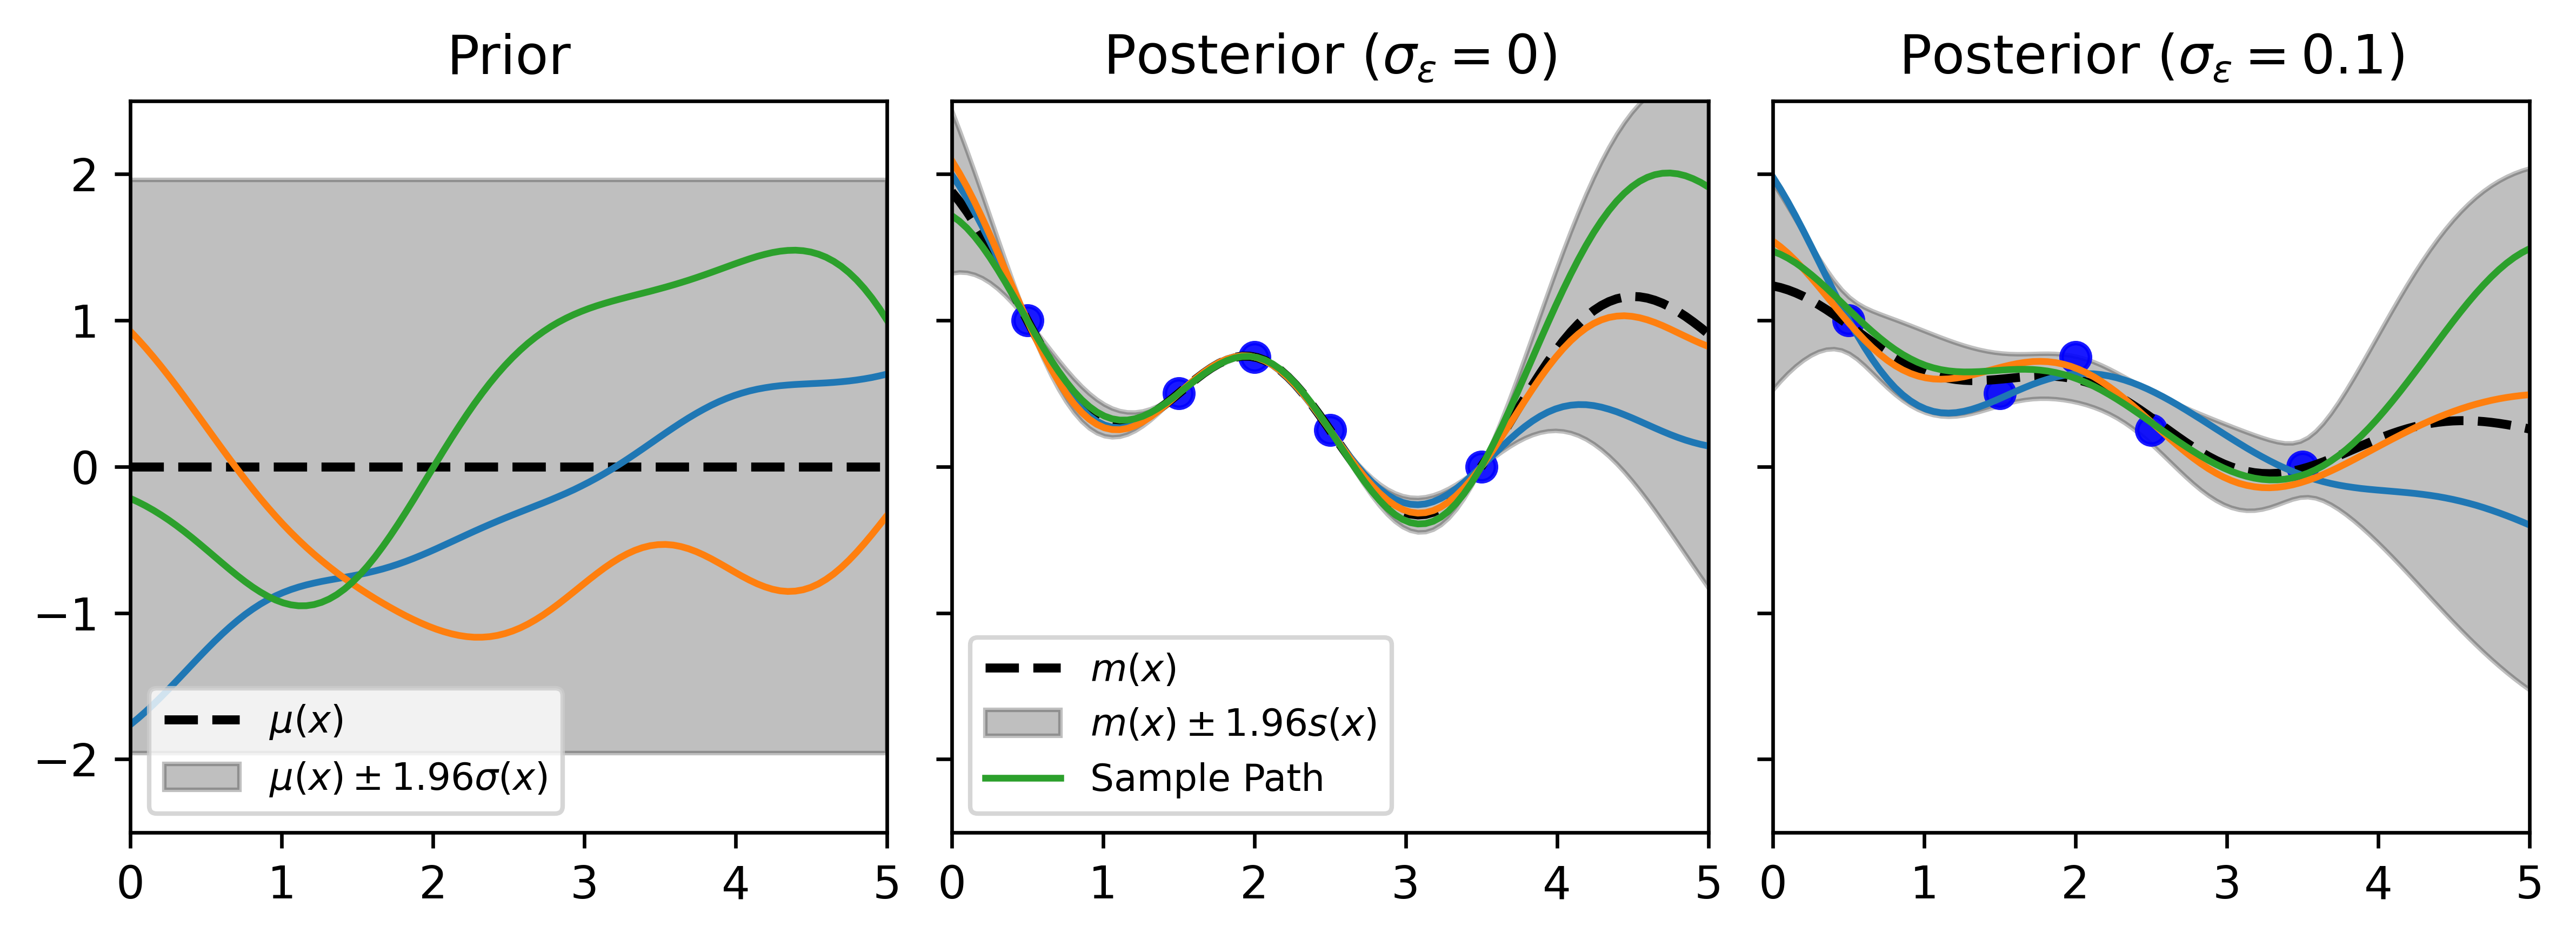

In [10]:
# Update plot parameters for font sizes
from matplotlib.lines import Line2D

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(8, 3), dpi=600)

# Plotting each panel
plot_graph(axes[0], np.array([]), np.array([]), predictions1, 'Prior', sim_list=model1_paths)
plot_graph(axes[1], x_train, y_train, predictions2, 'Posterior ($\sigma_{\epsilon} = 0$)', sim_list=model2_paths)
plot_graph(axes[2], x_train, y_train, predictions3, 'Posterior ($\sigma_{\epsilon} = 0.1$)', sim_list=model3_paths)

plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.show()

# Synthetic Univariate Case Study (Section 2.2)

In [11]:
# Set the random seed for reproducibility
seed = 127
torch.manual_seed(seed)
np.random.seed(seed)

In [12]:
def f(x):
      return -0.1  * x ** 2 + np.sin(3 * x)

In [13]:
# Parameters
N_low = 20  # Total number of samples for low N scenario
N_high = 40  # Total number of samples for high N scenario
noise = 0.4  # Noise level

In [14]:
x_train_low = np.linspace(1, 5, N_low, endpoint=False)  # equally spaced

y_train_low = f(x_train_low) + np.random.normal(0, noise, x_train_low.shape)

x_train_high_diff = np.hstack((   # non-uniformly spaced, and includes replicates
    np.linspace(1.1, 1.9, 5, endpoint=True),
    np.linspace(3.0, 4.0, 5, endpoint=False),
    np.linspace(3.0, 4.0, 5, endpoint=False),  # replicate these inputs twice each
    np.repeat(5.0, 5),  # replicate the same input x=5, 5 times
))

x_train_high = np.hstack((
    x_train_low,
    x_train_high_diff
))

y_train_high = np.hstack((
    y_train_low,
    f(x_train_high_diff) + np.random.normal(0, noise, x_train_high_diff.shape)
))
# Reshape the training data to 2D array for the model input
x_train_low = x_train_low.reshape(-1, 1)
x_train_high = x_train_high.reshape(-1, 1)

### Fit Models

We fit two GP models for the training sets ${\cal D}_{20}$ and ${\cal D}_{40}$:

In [15]:
# Create and fit the GPR models
m_low = GPRModel(train_x=x_train_low, train_y=y_train_low, kernel=rbf_kernel, mean=None)
m_low.fit_model(training_iterations=1000, lr = 0.1)
m_high = GPRModel(train_x=x_train_high, train_y=y_train_high, kernel=rbf_kernel, mean=None)
m_high.fit_model(training_iterations=1000, lr = 0.1)

Fitting complete.
--- 
--- final mll: -0.9341
--- num_params: 3
--- BIC: 23.1749
Fitting complete.
--- 
--- final mll: -0.7881
--- num_params: 3
--- BIC: 37.0588


GPRModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): Positive()
    )
  )
  (mean_module): ZeroMean()
  (kernel): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

We use the fitted models to predict over a grid covering $[0,6]$.

In [16]:
# Create a range of test inputs
x_test = torch.linspace(0, 6, 100)

# Make predictions
predictions_low = m_low.make_predictions(x_test.unsqueeze(1), type="f", return_type="numpy")
predictions_high = m_high.make_predictions(x_test.unsqueeze(1), type="f", return_type="numpy")

x_test_np = x_test.cpu().numpy().flatten()  # Convert x_test to a numpy array for plotting

In [17]:
# Function to plot the graphs
def plot_graph22(ax, x_train, y_train, predictions, title, color, legend=True, y_min = None, y_max = None):
    if y_min == None:
        y_min = 1.25*y_train.min()
    if y_max == None:
        y_max = 1.35*y_train.max()
    ax.scatter(x_train.flatten(), y_train, label='Training Data', color='blue', s=15, marker='o', alpha=0.6)
    ax.plot(x_test_np, predictions.mean, label='Mean Prediction', color=color, linewidth=1.5)
    ax.fill_between(x_test_np, predictions.mean - 1.96 * np.sqrt(predictions.variance),
                    predictions.mean + 1.96 * np.sqrt(predictions.variance), alpha=0.15, 
                    color=color, label='95% CI for $f(x)$')
    ax.plot(x_test_np, f(x_test_np), '--', label='True Function $f_0(x)$', color='black', linewidth=1)
    ax.set_ylim([y_min, y_max])            
    ax.set_xlim([x_test_np.min(), x_test_np.max()])  
    if legend:
        ax.legend(loc='lower left', fontsize=10, labelspacing=0.5, framealpha=0.8)
    ax.set_title(title)

The next plot displays the posterior mean and posterior 95% confidence intervals for the above models. For comparison, we also show (as a dashed line) the ground truth and the training sets. See **Figure 2.2** in the text. 

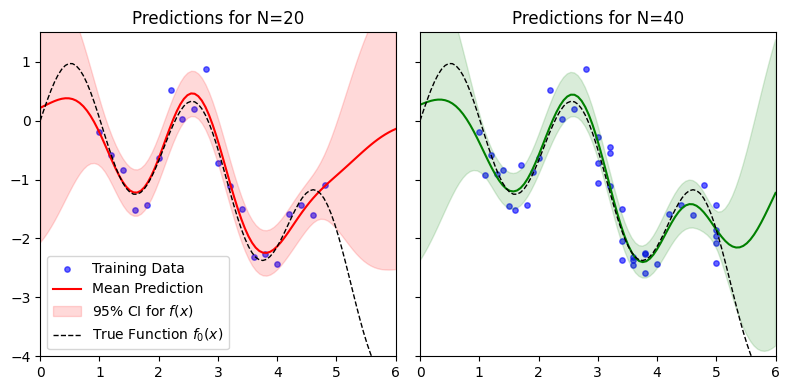

In [18]:
# Plot predictions for low N and high N

# Initialize a figure for the subplot panel
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)  # Add sharey=True to share the y-axis


y_min = -4.0
y_max = 1.5
plot_graph22(axes[0], x_train_low, y_train_low, predictions_low, f'Predictions for N={N_low}', 
           'red', y_min = y_min, y_max = y_max)
plot_graph22(axes[1], x_train_high, y_train_high, predictions_high, f'Predictions for N={N_high}', 
           'green', legend = False, y_min = y_min, y_max = y_max)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [19]:
print(m_low.get_hyperparameters_df())
print(f"sigma_eps = {m_low.likelihood.noise.sqrt().item()}")  # GPyTorch reports "noise" as sigma^2

print(m_high.get_hyperparameters_df())
print(f"sigma_eps = {m_high.likelihood.noise.sqrt().item()}")  # GPyTorch reports "noise" as sigma^2

              Hyperparameter Name  Estimate
0    likelihood.noise_covar.noise  0.131928
1              kernel.outputscale  1.553049
2  kernel.base_kernel.lengthscale  0.169516
sigma_eps = 0.3632192155914845
              Hyperparameter Name  Estimate
0    likelihood.noise_covar.noise  0.141215
1              kernel.outputscale  2.240873
2  kernel.base_kernel.lengthscale  0.169089
sigma_eps = 0.3757863715371125


We can also extract the likelihood scores to be able to construct BICs

In [20]:
def get_mll(model):
    model.train()
    ExactMarginalLogLikelihood = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
    output = model(model.train_x_scaled)

    mll = ExactMarginalLogLikelihood(output, model.train_y)
    return(mll)

## Impact of Hyperparameters (Section 2.3.2)

We start with the model based on 20 training inputs and use it as a baseline to understand how GP predictions change when hyperparameters vary.

In [21]:
lengthscale = 1.0
noise_var = 2.0

m1 = copy.deepcopy(m_low)
m1.kernel.base_kernel.lengthscale = lengthscale
m1.likelihood.noise = noise_var

# set parameters as fixed
m1.likelihood.raw_noise.requires_grad = False
m1.kernel.base_kernel.raw_lengthscale.requires_grad = False

# fit model
m1.fit_model()

# mll rounded to 4 decimals
np.round(get_mll(m1).item(),4)  

m_low.fit_model()

Fitting complete.
--- 
--- final mll: -1.5470
--- num_params: 3
--- BIC: 35.4326
Fitting complete.
--- 
--- final mll: -0.9341
--- num_params: 3
--- BIC: 23.1752


GPRModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): Positive()
    )
  )
  (mean_module): ZeroMean()
  (kernel): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [22]:
# Function to create a 3x3 panel plot for different lengthscales and noise levels
def create_hyperparam_plot(lengthscales, noise_vars, m_low, x_train, y_train, x_test):
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))
    
    # Calculate the y-axis limits
    # y_min = np.min(y_train) * 1.35
    # y_max = np.max(y_train) * 1.35
    y_min = -4.0
    y_max = 2.0
    
    for i, ls in enumerate(lengthscales):
        for j, nv in enumerate(noise_vars):
            # Deep copy the model to keep the original intact
            m = copy.deepcopy(m_low)
            # Set the new hyperparameters
            m.kernel.base_kernel.lengthscale = ls
            m.likelihood.noise = nv**2
            
            # Fix the parameters so they are not updated during fitting
            m.likelihood.raw_noise.requires_grad = False
            m.kernel.base_kernel.raw_lengthscale.requires_grad = False
            
            # Fit the model
            m.fit_model(training_iterations=1000, lr = 0.01)
            outputscale = np.round(copy.copy(m.kernel.outputscale).item(),2)  # Assuming outputscale is an attribute of the model
            
            # Get predictions
            predictions = m.make_predictions(x_test.unsqueeze(1), type="f", return_type="numpy")
            
            # Plotting
            ax = axes[i, j]
            ax.plot(x_test.cpu().numpy(), f(x_test.cpu().cpu().numpy()), '--', color='black', linewidth=1)
            ax.scatter(x_train.flatten(), y_train, color='blue', s=15, marker='o', alpha=0.5)
            ax.plot(x_test.cpu().numpy(), predictions.mean, color='red', linewidth=2)
            ax.fill_between(x_test.cpu().numpy(), predictions.mean - 1.96 * np.sqrt(predictions.variance),
                            predictions.mean + 1.96 * np.sqrt(predictions.variance), alpha=0.2, color='red')
            #ax.set_title(f'$\hat \eta^2={outputscale}$, $\ell(\\theta)= {np.round(mll,2)}$')
            ax.set_ylim([y_min, y_max])            
            ax.set_xlim([x_test.min().item(), x_test.max().item()])  

            # Move title inside the plot
            mll = np.round(get_mll(m).item(), 4)
            outputscale = np.round(np.sqrt(copy.copy(m.kernel.outputscale).item()),2)
            ax.text(0.5, 0.95, f'$\hat \eta={outputscale}$, $\ell(\\theta)= {np.round(mll,2)}$', 
                    transform=ax.transAxes, horizontalalignment='center', verticalalignment='top')

            # Show x and y axis values only for the middle plots
            if i ==1 and j == 0: 
                pass
            else:
                ax.set_yticklabels([])  # Hide y-axis labels except for middle left plot
            if i == 2 and j == 1: 
                pass
            else:
                ax.set_xticklabels([])  # Hide x-axis labels except for bottom middle plot

    # Faceting for Lengthscale and Noise Variance
    for i, ls in enumerate(lengthscales):
        ls_rounded = np.round(ls*4, 4)
        axes[i, 0].annotate('$\ell_{len}=' + f'{ls_rounded}$', xy=(0, 0.5), xytext=(-axes[i, 0].yaxis.labelpad - 5, 0),
                            xycoords=axes[i, 0].yaxis.label, textcoords='offset points',
                            size='large', ha='right', va='center', rotation=90)

    for j, nv in enumerate(noise_vars):
        nv_rounded = np.round(nv,3)
        axes[0, j].annotate(f'$\sigma = {nv_rounded}$', xy=(0.5, 1), xytext=(0, axes[0, j].xaxis.labelpad + 5),
                            xycoords='axes fraction', textcoords='offset points',
                            size='large', ha='center', va='baseline')

    # Adjust subplots
    plt.subplots_adjust(wspace=0.05, hspace=0.05)  # Adjust horizontal space

    plt.show()

### Figure 2.3:

We build a figure that has 9 panels, varying lengthscales $\ell_{len}$ on the y-axis (rows) and the noise variances $\sigma^2_\epsilon$ on the x-axis (columns). This matches **Figure 2.3** in the book.

Fitting complete.
--- 
--- final mll: -1.3344
--- num_params: 3
--- BIC: 31.1809
Fitting complete.
--- 
--- final mll: -1.0845
--- num_params: 3
--- BIC: 26.1844
Fitting complete.
--- 
--- final mll: -1.3780
--- num_params: 3
--- BIC: 32.0540
Fitting complete.
--- 
--- final mll: -3.7656
--- num_params: 3
--- BIC: 79.8055
Fitting complete.
--- 
--- final mll: -0.9680
--- num_params: 3
--- BIC: 23.8526
Fitting complete.
--- 
--- final mll: -1.2697
--- num_params: 3
--- BIC: 29.8885
Fitting complete.
--- 
--- final mll: -4.9375
--- num_params: 3
--- BIC: 103.2370
Fitting complete.
--- 
--- final mll: -1.2803
--- num_params: 3
--- BIC: 30.0981
Fitting complete.
--- 
--- final mll: -1.3146
--- num_params: 3
--- BIC: 30.7860


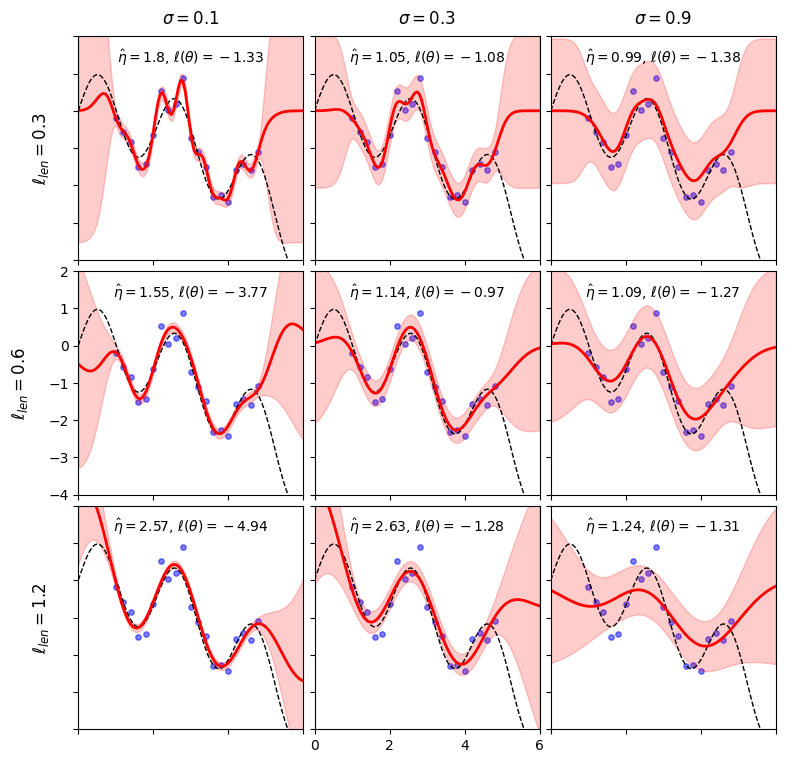

In [23]:
# Example usage:
lengthscales = [0.3/4, 0.6/4, 1.2/4]
noise_levels = [0.1, 0.3, 0.9]

x_test = torch.linspace(0, 6, 100)

create_hyperparam_plot(lengthscales, noise_levels, m_low, x_train_low, y_train_low, x_test)

## Prior Mean Modeling and Universal Kriging (Section 2.3.3)

We next investigate the role of the prior mean $\mu(x)$ using the Universal Kriging equations. To this end we compare a constant $\mu(x)$  to a linear and a quadratic prior mean.

``ConstantMean()`` and ``LinearMean()`` are available through ``gpytorch.means``, but we must define ``QuadraticMean()`` ourselves.

In [24]:
# Set the random seed for reproducibility
seed = 2024
torch.manual_seed(seed)
np.random.seed(seed)
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.means.mean import Mean

# Quadratic is not available by default, so we create it outselves.  
# The naming scheme is made consistent with LinearMean, meaning
#   mu(x) = bias + weights * x + weights2 * x^2
class QuadraticMean(Mean):
    def __init__(self, input_size, batch_shape=torch.Size(), bias=True):
        super().__init__()
        self.register_parameter(name="weights", parameter=torch.nn.Parameter(torch.randn(*batch_shape, input_size, 1)))
        self.register_parameter(name="weights2", parameter=torch.nn.Parameter(torch.randn(*batch_shape, input_size, 1)))
        if bias:
            self.register_parameter(name="bias", parameter=torch.nn.Parameter(torch.randn(*batch_shape, 1)))
        else:
            self.bias = None

    def forward(self, x):
        res = x.matmul(self.weights).squeeze(-1)
        res2 = x.pow(2).matmul(self.weights2).squeeze(-1)
        if self.bias is not None:
            res = res + res2 + self.bias
        return res

Now, fit the models. `lr` is the Adam learning rate. We use lower learning rate when there are more hyperparameters.

In [25]:
m_high = GPRModel(train_x=x_train_high, train_y=y_train_high, kernel=rbf_kernel, mean=None)
m_high.fit_model(training_iterations=1000, lr=0.1)
m_high_con = GPRModel(train_x=x_train_high, train_y=y_train_high, kernel=rbf_kernel, mean=ConstantMean())
m_high_con.fit_model(training_iterations=1000, lr=0.1)
m_high_lin = GPRModel(train_x=x_train_high, train_y=y_train_high, kernel=rbf_kernel, mean=LinearMean(input_size=1))
m_high_lin.fit_model(training_iterations=2000, lr=0.05)
m_high_quad = GPRModel(train_x=x_train_high, train_y=y_train_high, kernel=rbf_kernel, mean=QuadraticMean(input_size=1))
m_high_quad.fit_model(training_iterations=2000, lr=0.05)

Fitting complete.
--- 
--- final mll: -0.7881
--- num_params: 3
--- BIC: 37.0588
Fitting complete.
--- 
--- final mll: -0.7512
--- num_params: 4
--- BIC: 37.4275
Fitting complete.
--- 
--- final mll: -0.7166
--- num_params: 5
--- BIC: 37.8849
Fitting complete.
--- 
--- final mll: -0.7144
--- num_params: 6
--- BIC: 39.6442


GPRModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): Positive()
    )
  )
  (mean_module): QuadraticMean()
  (kernel): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

The next few chunks of code produce the hyperparameter MLEs in **Table 2.2**.  We use ``get_hyperparameters_df(scaled = False)`` which is a method for the ``GPRModel`` class as defined in ``easyGPR_helper.py``.  This will produce the original scale $\ell_{\text{len}}$ estimates.

Note that scaling is only done on hyperparameters dependent on the $x$ scale, so the $\eta^2$ and $\sigma_\epsilon$ estimates are reported on their original value.  Additionally, the $\beta$ estimate scaling is less straightforward, so it is done not as a part of the method but in the following chunk.

In [26]:
print(m_high.get_hyperparameters_df(scaled = False))
print(f"sigma_eps = {m_high.likelihood.noise.sqrt().item()}")
print(m_high_con.get_hyperparameters_df(scaled = False))
print(f"sigma_eps = {m_high_con.likelihood.noise.sqrt().item()}")
print(m_high_lin.get_hyperparameters_df(scaled = False))
print(f"sigma_eps = {m_high_lin.likelihood.noise.sqrt().item()}")
print(m_high_quad.get_hyperparameters_df(scaled = False))
print(f"sigma_eps = {m_high_quad.likelihood.noise.sqrt().item()}")

              Hyperparameter Name  Estimate
0    likelihood.noise_covar.noise  0.141215
1              kernel.outputscale  2.240873
2  kernel.base_kernel.lengthscale  0.676355
sigma_eps = 0.3757863715371125
              Hyperparameter Name  Estimate
0    likelihood.noise_covar.noise  0.142866
1            mean_module.constant -1.123910
2              kernel.outputscale  0.937225
3  kernel.base_kernel.lengthscale  0.546902
sigma_eps = 0.377976089186073
              Hyperparameter Name  Estimate
0    likelihood.noise_covar.noise  0.141850
1             mean_module.weights -1.923577
2                mean_module.bias -0.139566
3              kernel.outputscale  0.580656
4  kernel.base_kernel.lengthscale  0.500177
sigma_eps = 0.37662932145600275
              Hyperparameter Name  Estimate
0    likelihood.noise_covar.noise  0.141646
1             mean_module.weights -0.533131
2            mean_module.weights2 -1.348664
3                mean_module.bias -0.330246
4              kernel.outpu

This chunk unscales the $\beta$ coefficients to their original scale.

In [27]:
M = x_train_high.max()
m = x_train_high.min()

# Linear Model
beta1_orig = m_high_lin.mean_module.weights.item() / (M - m)
beta0_orig = m_high_lin.mean_module.bias.item() - beta1_orig * m
print(f"Linear Mean Estimates:")
print(f"-- beta0: {beta0_orig:.4f}")
print(f"-- beta1: {beta1_orig:.4f}")

# Quadratic Model
beta0 = m_high_quad.mean_module.bias.item()
beta1 = m_high_quad.mean_module.weights.item()
beta2 = m_high_quad.mean_module.weights2.item()

beta0_orig = (M**2 * beta0 - 2*M*beta0*m - M*beta1*m + beta0*m**2 + beta1*m**2 + beta2*m**2) / (M-m)**2
beta1_orig = (M*beta1 - beta1*m - 2*beta2*m) / (M-m)**2
beta2_orig = beta2 / (M-m)**2

print(f"Quadratic Mean Estimates:")
print(f"-- beta0: {beta0_orig:.4f}")
print(f"-- beta1: {beta1_orig:.4f}")
print(f"-- beta2: {beta2_orig:.4f}")

Linear Mean Estimates:
-- beta0: 0.3413
-- beta1: -0.4809
Quadratic Mean Estimates:
-- beta0: -0.2813
-- beta1: 0.0353
-- beta2: -0.0843


In [28]:
# Create a range of test inputs
x_test = torch.linspace(0, 8, 100)

# Make predictions
predictions_high_con = m_high_con.make_predictions(x_test.unsqueeze(1), type="f", return_type="numpy")
predictions_high_lin = m_high_lin.make_predictions(x_test.unsqueeze(1), type="f", return_type="numpy")
predictions_high_quad = m_high_quad.make_predictions(x_test.unsqueeze(1), type="f", return_type="numpy")
predictions_high = m_high.make_predictions(x_test.unsqueeze(1), type="f", return_type="numpy")

The next plot shows the three fits and their confidence intervals all together. Compare to **Figure 2.4** in Section 2.3.3.

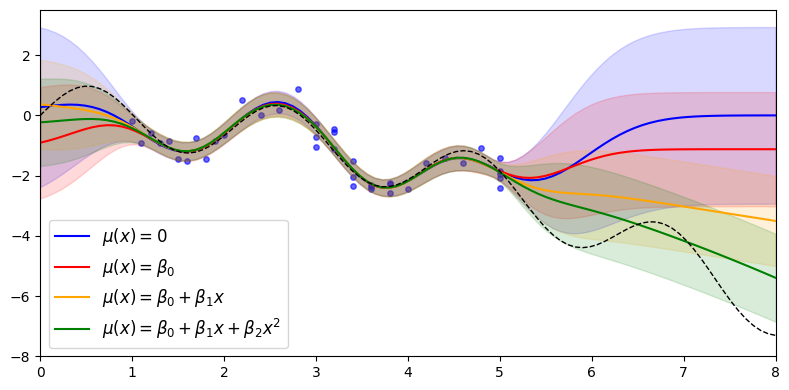

In [29]:
# Initialize a figure for the subplot panel
fig, axes = plt.subplots(1, 1, figsize=(8, 4), sharex=True)  # Add sharey=True to share the y-axis

x_test_np = x_test.cpu().numpy().flatten()  # Convert x_test to a numpy array for plotting

y_min = -8.0
y_max = 3.5

ax=axes
x_train=x_train_high
y_train=y_train_high

ax.scatter(x_train.flatten(), y_train, label=None, color='blue', s=15, marker='o', alpha=0.6)

for predictions, color,label in zip([predictions_high, predictions_high_con, predictions_high_lin,predictions_high_quad],
                                    ['blue','red','orange','green'],
                                    ['$\mu(x)=0$','$\mu(x)=\\beta_0$', '$\mu(x)=\\beta_0 + \\beta_1 x$',
                                     '$\mu(x)=\\beta_0 + \\beta_1 x + \\beta_2 x^2$']):
    ax.plot(x_test_np, predictions.mean, label=label, color=color, linewidth=1.5)
    ax.fill_between(x_test_np, predictions.mean - 1.96 * np.sqrt(predictions.variance),
                     predictions.mean + 1.96 * np.sqrt(predictions.variance), alpha=0.15, color=color,
                     label=None) 

ax.plot(x_test_np, f(x_test_np), '--', label=None, color='black', linewidth=1)
ax.set_ylim([y_min, y_max])
ax.set_xlim([x_test_np.min(), x_test_np.max()])
ax.legend(loc='lower left', fontsize=12, labelspacing=0.5, framealpha=0.8)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


We include an additional plot which shows the posterior mean and standard deviation of each model over $x \in [0,8]$.

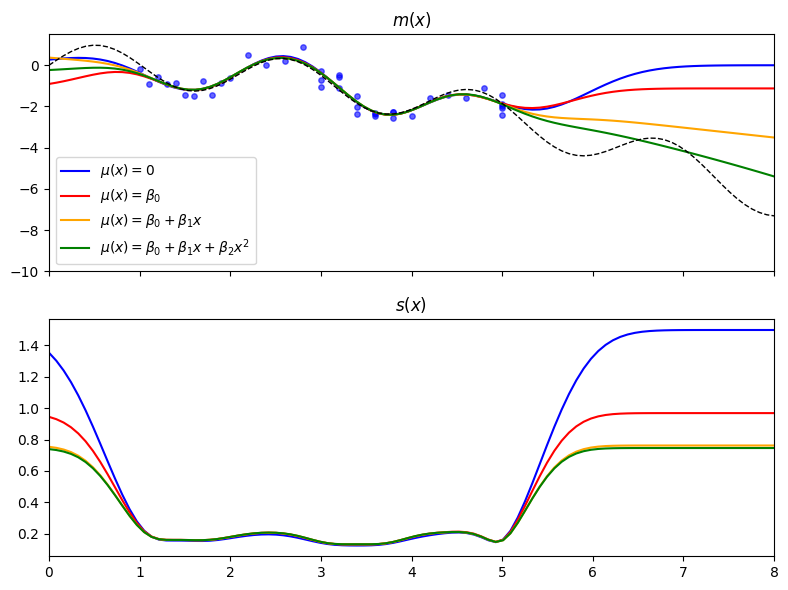

In [30]:
# Initialize a figure for the subplot panel
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)  # Add sharey=True to share the y-axis

x_test_np = x_test.cpu().numpy().flatten()  # Convert x_test to a numpy array for plotting

y_min = -10.0
y_max = 1.5

# Top subplot
ax=axes[0]
x_train=x_train_high
y_train=y_train_high

ax.scatter(x_train.flatten(), y_train, label=None, color='blue', s=15, marker='o', alpha=0.6)

for predictions, color,label in zip([predictions_high, predictions_high_con, predictions_high_lin,predictions_high_quad],
                                    ['blue','red','orange','green'],
                                    ['$\mu(x)=0$','$\mu(x)=\\beta_0$', '$\mu(x)=\\beta_0 + \\beta_1 x$',
                                     '$\mu(x)=\\beta_0 + \\beta_1 x + \\beta_2 x^2$']):
    ax.plot(x_test_np, predictions.mean, label=label, color=color, linewidth=1.5)
    
ax.plot(x_test_np, f(x_test_np), '--', label=None, color='black', linewidth=1)
ax.set_ylim([y_min, y_max])
ax.set_xlim([x_test_np.min(), x_test_np.max()])
ax.legend(loc='lower left', fontsize=10, labelspacing=0.5, framealpha=0.8)
ax.set_title('$m(x)$')

# Bottom subplot
ax=axes[1]
for predictions, color in zip([predictions_high, predictions_high_con, predictions_high_lin,predictions_high_quad],['blue','red','orange','green']):
    ax.plot(x_test_np, np.sqrt(predictions.variance), label='', color=color, linewidth=1.5)
ax.set_title('$s(x)$')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


---
## License

This notebook is licensed under the [MIT License](https://github.com/jimmyrisk/GP-Quant/blob/main/LICENSE).

Copyright (c) 2024 Jimmy Risk and Mike Ludkovski